# Advanced Time-Series Analysis and Deep Learning: Homework #3

## Motif Discovery

### Mathematical Formulation

(a): In time-series data, motifs are pairs of individual time series, or subsequences of longer time series, which are very similar to each other. A motif can tell us about recurring patterns within time series data!

(b): 
Let me formulate this mathematically. 

Case 1: Time Series Motif

I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

A Time Series Database $D$ is an unordered set of m time series possibly of different lengths.

The Time Series Motif of $D$ is the unordered pair of time series ${T_i, T_j}$ in D which is the most similar among all possible pairs

Essentially, $\forall a,b,i,j$, 

${T_i, T_j}$ is the motif iff $dist(T_i, T_j) ≤ dist(T_a, T_b)$, $i \neq j$ and $a \neq b$.


Case 2: Subsequence Motif

We can also calculate a Subsequence Motif. Given a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 
Let's say we have two subsequences $T_c$ and $T_d$

Essentially, $\forall c,d,i,j$, 

${T_c, T_d}$ is the subsequence motif iff $dist(T_c, T_d) ≤ dist(T_i, T_j)$, $i \neq j$ and $a \neq b$.



### Synthetic Data Generation

In [295]:
import numpy as np

### First Generate sine curve
n = 201

# t => [0, 10 * pi]
t = np.linspace(start = 0, stop = 20 * np.pi, num = n, endpoint = True)
x = np.sin(t)

#Generate Noise
noise = np.random.normal(loc = 0, scale = 2, size = (n,))

#Embed Motif
timestep = 10

for i in range(1, n // timestep, 8):
    pivot = timestep * i
    time_slice = t[pivot - 6 : pivot + 6]
    noise[pivot - 6 : pivot + 6] = np.cos(time_slice)
    print(np.rad2deg(time_slice) % 360, i)

x_adjusted = x + noise

[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 1
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 9
[ 72.  90. 108. 126. 144. 162. 180. 198. 216. 234. 252. 270.] 17


To generate a synthetic time-series dataset that includes at least one embedded motif, here are the steps I took: 
1. First I generated a normal sine curve. Let's call this x(t)
2. Then, I generated random Gaussian noise with a mean of 0 and a standard deviation of 2. Within this noise curve, I injected a pattern at periodic locations in order to have a recurring motif. Let's call this curve, after the injection of the pattern, n(t)
3. To generate my final curve, I just did x_adjusted(t) = x(t) + n(t)

Text(0.5, 1.0, 'Sine Curve')

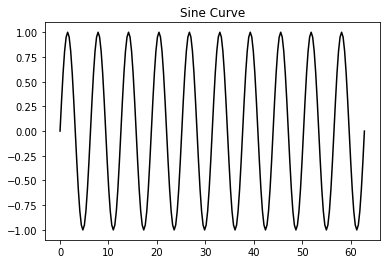

In [296]:
import matplotlib.pyplot as plt
plt.plot(t, x, label='sin(x)', color='black', linestyle='-')
plt.title("Normal Sine Curve (x(t))")

Text(0.5, 1.0, 'Noise with Injected Pattern')

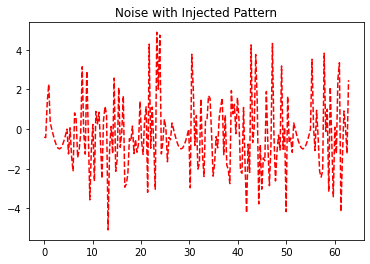

In [297]:
plt.plot(t, noise, label='noise', color='red', linestyle='--')
plt.title("Noise with Injected Pattern (n(t))")

Pivot: 10
Pivot: 90
Pivot: 170


Text(0.5, 1.0, 'Final Plot')

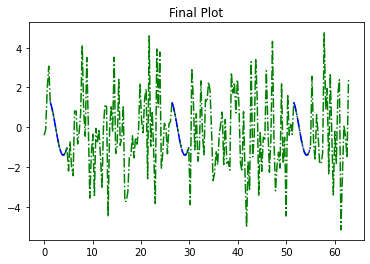

In [298]:
plt.plot(t, x_adjusted, color = 'green', linestyle='-.')  

for i in range(1, n // timestep, 8):
    pivot = timestep * i
    time_slice = t[pivot - 6 : pivot + 6]
    print(f"Pivot: {pivot}")
    plt.plot(time_slice, x_adjusted[pivot - 6 : pivot + 6], color = "blue", linestyle = '-.')

plt.title("Final Plot (x_adjusted(t))")

As you can see in this image, the embedded motif appears(i.e. colored in blue)

## Matrix Profile

General Concept: 
In time series analysis, a matrix profile is used to find anomalies and trends within time series data. 

Mathematical Formulation: 

1. I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

2. A subsequence $T_{i,m}$ of a T is a continuous subset of the values from T of length m starting from position i. $T_{i,m} = t_i, t_{i+1} ,…, t_{i+m-1}$, where $1 \leq i \leq n-m+1$.

3. A distance profile D is a vector of the Euclidean distances between a given query and each subsequence in an all-subsequences set

4. An all-subsequences set A of a time series T is an ordered set of all possible subsequences of T obtained by sliding a window of length m across T: 

$A ={T_{1,m},, T_{2,m},…, T_{n-m+1,m}}$, where m is a user-defined subsequence length. We use A[i] to denote $T_{i,m}$.

5. 1NN-join function: given two all-subsequences sets A and B and two subsequences A[i] and B[j], a 1NN-join function $\theta_{1nn}$ (A[i], B[j]) is a Boolean
function which returns “true” only if B[j] is the nearest neighbor of A[i] in the set B.

6. Similarity join set: given all-subsequences sets A and B, a similarity join set $J_{AB}$ of A and B is a set containing pairs of each subsequence in A with its nearest neighbor in B: $J_{AB}={〈 A[i], B[j] 〉| θ_{1nn} (A[i], B[j])}$ . We denote this formally as $J_{AB} = A \bowtie_{\theta_{1nn}} B$.

7. A matrix profile (or just profile) $P_{AB}$ is a vector of the Euclidean distances between each pair in $J_{AB}$

### Algorithm Implementation

In [299]:
def generate_subsequences_set(T, M):
    N = len(T) - M + 1
    indices = np.arange(M) + np.arange(N)[:, np.newaxis]
    return T[indices]

Given a time series T and a window length M, this function(generate_subsquences_set) creates a list of all contiguous subsequences of length M from the Time Series T

In [300]:
# A: List of contiguous subsequences of length M from the Time Series T
def generate_matrix_profile(A):
    N, M = A.shape[0], A.shape[1]
    
    exclusion = np.ceil(M / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
        
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = np.linalg.norm(A[i] - A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

The input to the function generate_matrix_profile is "A", which represents the list of all contiguous subseequences of length M from the time series T. This function returns two arrays, "distances" and "indices". Let the length of "A" be N. For each index i where 0 $\leq$ i $\leq$ N - 1, distances[i] represents the distance between A[i] and its nearest neighbor and indices[i] = j such that A[j] is the nearest neighbor of A[i]. 

### Matrix Profile Algorithm Implementation

In [301]:
T = x_adjusted
M = 12
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]
index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[ 4 84]
[84.  4.]
[5.57327535e-15 5.57327535e-15]


In [302]:
pivot = timestep * 1
time_period = t[pivot - 6 : pivot + 6]
print(f"Times: {time_period}")
print("----------------------------------------------------------------------------------------")
print(f"Motif Values: {np.sin(time_period) + np.cos(time_period)}")
print("----------------------------------------------------------------------------------------")

print(f"Subsequences: {A[ix]}")


Times: [1.25663706 1.57079633 1.88495559 2.19911486 2.51327412 2.82743339
 3.14159265 3.45575192 3.76991118 4.08407045 4.39822972 4.71238898]
Values: [ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
 -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]
Subsequences: [[ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
  -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]
 [ 1.26007351  1.          0.64203952  0.22123174 -0.22123174 -0.64203952
  -1.         -1.26007351 -1.39680225 -1.39680225 -1.26007351 -1.        ]]


As shown by this print output, when we found the subsequences with the minimum distance to its nearest neighbor(i.e. nearest subsequenc of the time series by Euclidean Distance), we can see that it matches the Motif Values!

### Optimized Matrix Profile Algorithm Implementation

In [303]:
### Optimize Matrix Profile Algorithm using FFT Approach outlined in paper
def sliding_dot_product(Q, T):
    n, m = len(T), len(Q)
    Ta = np.append(T, np.zeros(n))
    Qr = np.flip(Q)
    Qra = np.append(Qr, np.zeros(2 * n - m))
    Qraf, Taf = np.fft.fft(Qra), np.fft.fft(Ta)
    QT = np.fft.ifft(Qraf * Taf)
    return QT

def compute_mean_std(Q, T):
    uq = np.mean(Q)
    stdev_Q = np.std(Q)
    n,m = len(T), len(Q)
    
    M = np.zeros(shape = (n - m + 1,))
    Sigma = np.zeros(shape = (n - m + 1,))
    window = T[0:m]
    
    M[0] = np.mean(window)
    Sigma[0] = np.std(window)
    
    total = np.sum(window)
    total_elements_squared = np.sum(window ** 2)
    
    window_start = 0
    window_end = m - 1
    
    for index in range(1, n - m + 1):
        total = total - T[window_start] + T[window_end + 1]
        total_elements_squared = total_elements_squared - (T[window_start] ** 2) + (T[window_end + 1] ** 2)
        
        M[index] = total / m
        Sigma[index] = np.sqrt((total_elements_squared - (2 * M[index] * total) + ((M[index] ** 2) * m)) / m)
        
        window_start += 1
        window_end += 1
    
    return uq, stdev_Q, M, Sigma

def calculate_distance_profile(Q, T, QT, uq, stdev_Q, M, Sigma):
    n,m = len(T), len(Q)
    QT = QT[m - 1: n]
    D = np.sqrt(2 * m * (1 - ((QT - m * uq * M) / (m * stdev_Q * Sigma))))
    return D

def MASS(Q, T):
    QT = sliding_dot_product(Q, T)
    uq, stdev_Q, M, Sigma = compute_mean_std(Q, T)
    D = calculate_distance_profile(Q, T, QT, uq, stdev_Q, M, Sigma)
    return D

def optimized_matrix_profile(A):
    distance_profile = np.zeros(shape = (len(A),))
    index_profile = np.zeros(shape = (len(A),))
    
    for index in range(len(A)):
        row = A[index]
        distances = MASS(row, T)
        distance_profile[index] = np.min(distances)
        index_profile[index] = np.argmin(distances)
    
    return distance_profile, index_profile

This is an implementation of the STAMP Algorithm outlined in the paper "Matrix Profile I: All Pairs Similarity Joins for Time Series: A Unifying View that Includes Motifs, Discords and Shapelets". This algorithm relies on FFT(Fast Fourier Transform) to compute Euclidean distances between a subsequence and subsequences in the original time sries. 

### Testing Optimized Matrix Profile Algorithm Implementation

In [304]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = optimized_matrix_profile(A)

#To find a motif, we need to find a minimum value in the distance profile 
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

/var/folders/_z/7xh85xcn7rd84tynktgvzyrr0000gn/T/ipykernel_35353/1651943575.py:60: ComplexWarning: Casting complex values to real discards the imaginary part
  distance_profile[index] = np.min(distances)


[80]
[80.]
[3.73023075e-12]


## Discord Identification

1. Time series discords are subsequences of longer time series that are maximally different to the rest of the time series subsequences. 

Mathematical Formulation: 

- I will define a time series $T$ where $T = [t_1, t_2, ...., t_n ]$ consists of a set of $n$ real numbers. 

- We can define a subsequence $C$ of length $m$, where $m \leq n$, which is a contiguous slice from $T$. 

$C = [t_p, t_{p + 1}, ...., t_{p+n-1}]$ for $1 \leq p \leq m - n + 1$

- Given two subsequences, $C$ and $B$, we can define a function $D$ such that $D(B, C) = R$ where $R$ is a non-negative number and represents the distance between $B$ and $C$. 

- Non-Self Match: : Given a time series T, containing a subsequence C of length n beginning at position p and a matching subsequence B beginning at q, we say that B is a non-self match to C at distance of $D(B, C)$ if $|p - q| \geq n$

- Time Series Discord: Given a time series T, the subsequence A of length n beginning at position $i$ is said to be the discord of T if A has the largest distance to its nearest non-self match. $\forall C \in T$, let $M_C$ be any arbitrary non-self match of $C$ and $M_A$ be any arbitrary non-self match of $A$. We want the following to be true: 

$min(D(A, M_D)) > min(D(C, M_C))$


### Implementation of Discord Identification Algorithm

In [305]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)

#To find a motif, we need to find a maximum value in the distance profile 
ix = np.where(distance_profile == np.max(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[67]
[177.]
[7.5456371]


### HOT SAX

In [306]:
#Define Gaussian Distribution
mean = np.mean(T)
var = np.var(T)
stdev = np.sqrt(var)

# mean - 2 * stdev [A], mean - stdev [B], mean [C], mean + stdev [D], mean + 2 * stdev [E]
def discretize_window(window):
    u = np.mean(window)
    if u <= mean - 2 * stdev:
        return 'A'
    elif u <= mean - stdev:
        return 'B'
    elif u <= mean:
        return 'C'
    elif u <= mean + stdev:
        return 'D'
    elif u <= mean + 2 * stdev:
        return 'E'
    else:
        return 'F'

def generate_word(T, P):
    return np.apply_along_axis(discretize_window, axis = 1, arr = generate_subsequences_set(T, P)).flatten()

def edit_distance(W1, W2):
    if len(W2) == 0:
        return len(W1)

    if len(W1) == 0:
        return len(W2)
    
    if W1[0] == W2[0]:
        return edit_distance(W1[1:], W2[1:])
    
    return 1 + min(edit_distance(W1[1:], W2), edit_distance(W1, W2[1:]), edit_distance(W1[1:], W2[1:]))


def generate_SAX_matrix_profile(T, P):
    W = generate_word(T, P)
    L = M // P #letter subsequence length
    
    A = generate_subsequences_set(W, L)
    N = len(A)
    
    exclusion = np.ceil(L / 2)
    distances = np.zeros(shape = (N,))
    indices = np.zeros(shape = (N,))
    
    for i in range(N):
        bound1 = max(0, i - exclusion)
        bound2 = min(i + exclusion, N - 1)
                
        min_distance = float('inf')
        min_index = None
        
        for j in range(N):
            if bound1 <= j and j <= bound2: continue 
            d = edit_distance(A[i], A[j])
            if d < min_distance:
                min_distance = d
                min_index = j
        
        distances[i] = min_distance
        indices[i] = min_index
    
    return distances, indices

In [307]:
#To find a motif, we need to find a minimum value in the distance profile 
distance_profile, index_profile = generate_SAX_matrix_profile(T, P = 3)
ix = np.where(distance_profile == np.min(distance_profile))[0]

index_profile_ix = index_profile[ix]
distance_profile_ix = distance_profile[ix]

print(ix)
print(index_profile_ix)
print(distance_profile_ix)

[  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  99 100 101 102 103 108 109 110 111 112 113 116 117 118
 119 120 121 124 125 126 127 128 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 147 148 149 150 151 152 153 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 182 183 184 185 186 187 188 189 191 192 195]
[ 24.  19.  26.  27.  28.  11.  12.  13.   8.   8.   8.   8.   8.  36.
  41.  42.   4.   4. 103. 182.  73.   3.   4.   5.   6.   7.   8.   8.
   8.   8.   8.   8.   8.  16. 113. 116.   7.  16.  17.  18.   4.   4.
   4.   4.   4.   5.   6. 192. 130. 131. 132.   8.   8.   8.  16.  17.
  18.   4.   

# Deep Neural Network

Implement a Deep Neural Network from scratch for a simple classification prob- lem, excluding the backpropagation algorithm. [20 points]

In [308]:
import numpy as np

class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1, self.b1, self.W2, self.b2 = self.initialize_parameters()

    def initialize_parameters(self):
        # Initialize weights and biases
        # TODO: Initialize W1, b1, W2, and b2
        
        #Shape of W1: (hidden_dim, input_dim)
        W1 = np.random.randn(self.hidden_dim, self.input_dim) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of b1: (hidden_dim)
        b1 = np.random.randn(self.hidden_dim, 1) * np.sqrt(1 / (self.input_dim + self.hidden_dim))
        
        #Shape of W2: (output_dim, hidden_dim)
        W2 = np.random.randn(self.output_dim, self.hidden_dim) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        #Shape of b2: (output_dim)
        b2 = np.random.randn(self.output_dim, 1) * np.sqrt(1 / (self.hidden_dim + self.output_dim))
        
        return W1, b1, W2, b2

    def sigmoid(self, Z):
        # Sigmoid activation function
        # TODO: Implement sigmoid activation
        return 1 / (1 + np.exp(-1 * Z))

    def forward_propagation(self, X):
        # Forward propagation
        # TODO: Implement forward propagation
        
        Z1 = self.W1 @ X + np.tile(self.b1, reps = (1, X.shape[1]))
        A1 = self.sigmoid(Z1)
        
        Z2 = self.W2 @ A1 + np.tile(self.b2, reps = (1, A1.shape[1]))
        A2 = self.sigmoid(Z2)
        
        return Z1, A1, Z2, A2

    def compute_cost(self, A2, Y):
        # Compute the cost
        # TODO: Implement cost computation
        
        #Clip values to avoid log(0) :) 
        epsilon = 1e-20
        A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
        
        loss = - (Y * np.log(A2_clipped) + (1 - Y) * np.log(1 - A2_clipped))
        average_loss = np.mean(loss)
        
        return average_loss

    def backpropagation(self, X, Y, Z1, A1, Z2, A2):
        grads = {}
        m = X.shape[1]

        # Compute gradients
        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        dZ1 = np.dot(self.W2.T, dZ2) * (A1 * (1 - A1))
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2

        return grads

    def update_parameters(self, grads, learning_rate):
        # Update weights and biases
        self.W1 -= learning_rate * grads['dW1']
        self.b1 -= learning_rate * grads['db1']
        self.W2 -= learning_rate * grads['dW2']
        self.b2 -= learning_rate * grads['db2']


    def train(self, X, Y, learning_rate, num_iterations):
        for i in range(num_iterations):
            Z1, A1, Z2, A2 = self.forward_propagation(X)
            cost = self.compute_cost(A2, Y)
            grads = self.backpropagation(X, Y, Z1, A1, Z2, A2)
            self.update_parameters(grads, learning_rate)
            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost}")

if __name__ == "__main__":
    # Generate synthetic data
    X = np.random.rand(2, 500)
    Y = np.random.randint(0, 2, size=(1, 500))

    # Initialize the neural network
    nn = SimpleNN(2, 4, 1)

    # Train the neural network
    nn.train(X, Y, learning_rate=0.01, num_iterations=1000)

Iteration 0, Cost: 0.7191530917071618
Iteration 100, Cost: 0.7022692303933628
Iteration 200, Cost: 0.6957265804928922
Iteration 300, Cost: 0.6932097592936108
Iteration 400, Cost: 0.6922431564386928
Iteration 500, Cost: 0.6918717765316849
Iteration 600, Cost: 0.6917288799422207
Iteration 700, Cost: 0.6916737274799188
Iteration 800, Cost: 0.6916522883643533
Iteration 900, Cost: 0.6916438082004202


# Convolutional Neural Network

Complete the convolution code below. [10 points]

In [309]:
import numpy as np

def convolution2D(image, kernel):
    # Get the dimensions of the image and kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Calculate the output dimensions
    output_height = image_height - kernel_height + 1
    #TODO: Compute the output height
    output_width = image_width - kernel_width + 1
    #TODO: Compute the output width
    
    # Initialize the output feature map
    output = np.zeros((output_height, output_width))
    
    # Perform 2D convolution
    for i in range(output_height):
        for j in range(output_width):
            # Extract the region of interest (ROI) from the image
            #todo: Extract the region of interest (ROI) from the image
            
            ROI = image[i:i+kernel_height, j:j+kernel_width]
            
            # Compute the element-wise multiplication and sum
            #todo: Compute the element-wise multiplication and sum
            output[i][j] = np.sum(ROI * kernel)
    
    return output

# Example usage:
if __name__ == "__main__":
    # Create a sample grayscale image (8x8 pixels)
    image = np.array([[1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1],
                      [1, 2, 3, 4, 5, 6, 7, 8],
                      [8, 7, 6, 5, 4, 3, 2, 1]])
    
    # Create a sample kernel (3x3)
    kernel = np.array([[1, 0, -1],
                       [1, 0, -1],
                       [1, 0, -1]])
    
    # Perform 2D convolution
    result = convolution2D(image, kernel)
    print(result)

[[-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]]


# Integrated Application

Implement an end-to-end pipeline for automated time series classification that inte- grates motif and discord detection with deep learning. [10 Bonus Points]

In [310]:
import pandas as pd

## Load a Multivariate Time Series Dataset
delhi_train = pd.read_csv("DailyDelhiClimateTrain.csv")
delhi_test = pd.read_csv("DailyDelhiClimateTest.csv")

In [311]:
delhi_train

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [312]:
delhi_test

,date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,15.913043,85.869565,2.743478,59.000000
1,2017-01-02,18.500000,77.222222,2.894444,1018.277778
2,2017-01-03,17.111111,81.888889,4.016667,1018.333333
3,2017-01-04,18.700000,70.050000,4.545000,1015.700000
4,2017-01-05,18.388889,74.944444,3.300000,1014.333333
...,...,...,...,...,...
109,2017-04-20,34.500000,27.500000,5.562500,998.625000
110,2017-04-21,34.250000,39.375000,6.962500,999.875000
111,2017-04-22,32.900000,40.900000,8.890000,1001.600000
112,2017-04-23,32.875000,27.500000,9.962500,1002.125000


In [313]:
## Use the matrix profile and HOT SAX algorithms to identify motifs and discords in the time series data. These can help discover salient patterns and anomalies.

## This will be done on the training data

#Convert the delhi training dataframe to matrix. We don't need to include the date in our matrix!
T = delhi_train[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12

In [314]:
A = generate_subsequences_set(T, M)
distance_profile, index_profile = generate_matrix_profile(A)
distance_profile, index_profile

(array([36.02482202, 39.82550022, 38.36494455, ..., 41.48702351,
        40.19443415, 38.54110535]),
 array([  15., 1082., 1083., ...,    7.,  412.,  413.]))

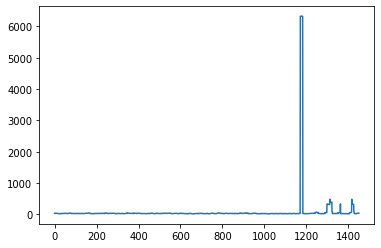

In [315]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.show()

In [316]:
#Let's put the distance profiles on a distribution
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])

labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

In [317]:
### Define a 1D Convolutional Neural Network via PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1D(nn.Module):
    def __init__(self, input_length, in_channels, num_filters, kernel_size, pool_kernel_size, output_fc_1, output_fc_2):
        super().__init__()
        
        #Define Structure of CNN
        self.L = input_length
        self.K = kernel_size
        self.P = pool_kernel_size
        self.Cin = in_channels
        self.Cout = num_filters
        
        self.output_fc_1 = output_fc_1
        self.output_fc_2 = output_fc_2
        
        #1D Convolution
        self.conv = nn.Conv1d(in_channels = self.Cin, out_channels = self.Cout, kernel_size = self.K)
        
        #Pooling Layer
        self.pool = nn.MaxPool1d(self.P)
        
        conv_L = self.L - self.K + 1

        # Fully connected layer
        self.fc1 = nn.Linear((int(0.5 * (conv_L - self.P)) + 1) * self.Cout, self.output_fc_1)
        self.fc2 = nn.Linear(self.output_fc_1, self.output_fc_2)
        
        #Sigmoid Function
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        #Start with Convolution and Pooling Layers
        x = self.conv(input)        
        x = self.pool(x)
        
        #Run through fully connected layers
        x = torch.flatten(x, 1)                
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        #Run through sigmoid
        x = self.sigmoid(x)      
        return torch.flatten(x)

In [318]:
import torch.optim as optim
def train(model, input, labels, epochs):
    optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)
    loss_fn = nn.BCELoss(reduction = 'mean')
    for epoch in range(epochs):        
        #Zero out gradients
        optimizer.zero_grad()
        
        #Run Forward Pass, Backward Propagation, then update weights
        outputs = model(input)        
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #Pring Loss        
        print(f'[Epoch {epoch + 1}] loss: {loss.item():.3f}')

In [319]:
shape = A.shape
model = CNN1D(shape[1], shape[2], 3, 3, 2, 6, 1).to(torch.float32)

A = torch.permute(torch.from_numpy(A), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

print(A.size())
print(labels.size())

torch.Size([1451, 4, 12])
torch.Size([1451])


In [320]:
train(model, A, labels, 10)

[1] loss: 0.704
[2] loss: 0.704
[3] loss: 0.703
[4] loss: 0.701
[5] loss: 0.699
[6] loss: 0.697
[7] loss: 0.695
[8] loss: 0.693
[9] loss: 0.693
[10] loss: 0.693


In [321]:
T2 = delhi_test[['meantemp', 'humidity', 'wind_speed', 'meanpressure']].to_numpy()

#Set window to 12 days
M = 12
A2 = generate_subsequences_set(T2, M)
distance_profile, index_profile = generate_matrix_profile(A2)

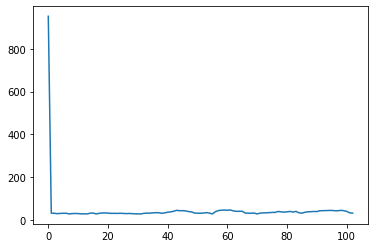

In [322]:
import matplotlib.pyplot as plt
plt.plot(distance_profile)
plt.show()

In [323]:
#Let's put the distance profiles on a distribution
u = np.mean(distance_profile)
std = np.std(distance_profile)
z_scores = np.array([(x - u) / std for x in distance_profile])
labels = np.array([1 if np.abs(z_score) < 2 else 0 for z_score in z_scores])

In [324]:
A2 = torch.permute(torch.from_numpy(A2), (0, 2, 1)).to(torch.float32)
labels = torch.from_numpy(labels).to(torch.float32)

In [325]:
correct = 0
total = 0
loss_fn = nn.BCELoss(reduction = 'mean')

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    # calculate outputs by running input through the network
    outputs = model(A2)
    
    predictions = (outputs >= 0.5).int().to(torch.float32)
    
    total += labels.size(0)
    correct += (predictions == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')


Accuracy of the network on the 10000 test images: 99 %
